# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

# AUTHOR

In [1]:
# 5th Project of the Deep Learning Foundation Udacity's Nanodegree
# Author: Daniel Abrantes Formiga

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

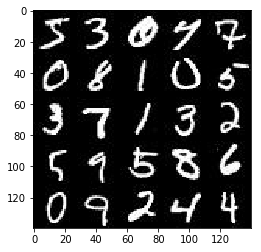

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

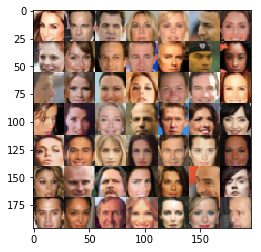

In [4]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1


C:\Users\NOTEBOOK\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    # Inputs placeholders
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='real_input')
    z_input    = tf.placeholder(tf.float32, [None, z_dim], name='z_input')
    learn_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return real_input, z_input, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\Users\\NOTEBOOK\\Anaconda3\\envs\\tensorflow_env\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\Users\\NOTEBOOK\\Anaconda3\\envs\\tensorflow_env\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\Users\\NOTEBOOK\\Anaconda3\\envs\\tensorflow_env\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "C:\\Users\\NOTEBOOK\\Anaconda3\\envs\\tensorflow_env\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\Users\\NOTEBOOK\\Anaconda3\\envs\\tensorflow_env\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, in s

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    # The convolutional neural network will be used due to the inputs are images
    
    # Alpha value for leaky ReLU
    alpha = 0.2
    
    # Variable scope discriminator
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # First conv layer 
        conv1 = tf.layers.conv2d(images, 64, 5, 
                                 strides=2, 
                                 padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        # Leaky ReLU - There is no batch normalization in the firs input layer
        leak_relu1 = tf.maximum(alpha * conv1, conv1)
        
        # Second conv layer 
        conv2 = tf.layers.conv2d(leak_relu1, 128, 5,
                                 strides=2,
                                 padding='same',
                                 kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        # Batch normalizing before the leaky ReLU
        batch_norm1 = tf.layers.batch_normalization(conv2, training=True)
        # Leaky ReLU
        leak_relu2  = tf.maximum(alpha * batch_norm1, batch_norm1)
        
        # Third conv layer
        conv3 = tf.layers.conv2d(leak_relu2, 256, 4,
                                 strides=1,
                                 padding='valid',
                                 kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        # Batch normalizing before the leaky ReLU
        batch_norm2 = tf.layers.batch_normalization(conv3, training=True)
        # Leaky ReLU
        leak_relu3  = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # Reshaping image
        leak_relu3_dim = leak_relu3.get_shape().as_list()
        reshape_dim = leak_relu3_dim[1] * leak_relu3_dim[2] * leak_relu3_dim[3]
        flatten_data = tf.reshape(leak_relu3, (-1, reshape_dim))
        
        # Dense layer
        logits = tf.layers.dense(flatten_data, 1, 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        discrim_output = tf.sigmoid(logits)
        
        
        
        
    return discrim_output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # Alpha value for leaky ReLU
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        # Dense layer
        dense_layer = tf.layers.dense(z, 4*4*512,
                                      kernel_initializer=tf.contrib.layers.xavier_initializer())
    
        # Reshaping the data 
        data_reshape = tf.reshape(dense_layer, (-1, 4, 4, 512))
        
        # Batch normalization
        batch_norm1 = tf.layers.batch_normalization(data_reshape, training=is_train)
        # Leaky ReLU
        leak_relu1 = tf.maximum(alpha * batch_norm1, batch_norm1)
        
        # First transpose conv layer
        conv1 = tf.layers.conv2d_transpose(leak_relu1, 256, 4,
                                           strides=1,
                                           padding='valid',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        # Batch normalization 
        batch_norm2 = tf.layers.batch_normalization(conv1, training=is_train)
        # Leaky ReLU
        leak_relu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # Second transpose conv layer
        conv2 = tf.layers.conv2d_transpose(leak_relu2, 128, 5,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        # Batch normalization 
        batch_norm3 = tf.layers.batch_normalization(conv2, training=is_train)
        # Leaky ReLU
        leak_relu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        
        # Third transpose conv layer
        logits = tf.layers.conv2d_transpose(leak_relu3, out_channel_dim, 5,
                                            strides=2,
                                            padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())

        gen_output = tf.tanh(logits)
    
    
    return gen_output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # Generator
    gen_output = generator(input_z, out_channel_dim, is_train=True)
    
    # Discriminator with real data
    discr_real, d_logits = discriminator(input_real, reuse=False)
    
    # Discriminator with generated data
    discr_fake, d_gen_logits = discriminator(gen_output, reuse=True)
    
    # Discriminator real data loss
    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits, labels=tf.ones_like(discr_real) * 0.9))
    
    # Discriminator fake data loss
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_gen_logits, labels=tf.zeros_like(discr_fake)))
    
    # Discriminator total loss
    d_loss = d_real_loss + d_fake_loss
    
    # Generator loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_gen_logits, labels=tf.ones_like(discr_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Getting all the trainable variables
    nn_variables = tf.trainable_variables()
    
    # Getting the generator trainable variables
    gen_variables = [var for var in nn_variables if var.name.startswith('generator')]
    
    # Getting the discriminator trainable variables
    disc_variables = [var for var in nn_variables if var.name.startswith('discriminator')]
    
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        # Optimizing the loss of the generator
        gen_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss,
                                                                                            var_list=gen_variables)
        # Optimizing the loss of the discriminator
        disc_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, 
                                                                                             var_list=disc_variables)
    
    return disc_opt, gen_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Model inputs
    input_real, input_z, learn_rate = model_inputs(image_width=data_shape[1],
                                                   image_height=data_shape[2],
                                                   image_channels=data_shape[3],
                                                   z_dim=z_dim)
    
    # Model loss
    d_loss, g_loss = model_loss(input_real=input_real, 
                                input_z=input_z,
                                out_channel_dim=data_shape[3])
    
    # Model optimizer
    d_opt, g_opt = model_opt(d_loss=d_loss,
                             g_loss=g_loss,
                             learning_rate=learn_rate,
                             beta1=beta1)
    
    
    # Train saver
    train_saver = tf.train.Saver()
    
    # The number of batches to show images
    show_images = 100
    
    # Number of batches to print loss
    print_loss = 25
    
    # Training iterations
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
    
            # Batch count for generating images
            batch_count = 0
            
            for batch_images in get_batches(batch_size):
                # Batch count update
                batch_count += 1
                
                # Scaling batch_images to [-1, 1]
                batch_images_scaled = 2 * batch_images
                
                # Random data for the generator input
                z_input = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Optimizers and losses calculation
                _, train_d_loss = sess.run([d_opt, d_loss], feed_dict={input_real: batch_images_scaled,
                                                                       input_z: z_input,
                                                                       learn_rate: learning_rate})
                
                _, train_g_loss = sess.run([g_opt, g_loss], feed_dict={input_z: z_input,
                                                                       input_real: batch_images_scaled, 
                                                                       learn_rate: learning_rate})
                
                # Printing loss
                if batch_count % 10 == 0:
                    print('Batch: {},  Generator Loss: {:.3f}, Discriminator Loss: {:.3f}'.format(batch_count,
                                                                                                     train_g_loss,
                                                                                                     train_d_loss
                                                                                                    ))
                
                # Showing images
                if batch_count % 100 == 0:
                    
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    
        
        # Saving the model
        train_saver.save(sess, './chekpoints/face_gen.ckpt')
        print('Model trained and saved')
        
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Batch: 10,  Generator Loss: 4.848, Discriminator Loss: 1.349
Batch: 20,  Generator Loss: 4.711, Discriminator Loss: 1.527
Batch: 30,  Generator Loss: 1.543, Discriminator Loss: 1.334
Batch: 40,  Generator Loss: 1.487, Discriminator Loss: 1.153
Batch: 50,  Generator Loss: 3.558, Discriminator Loss: 1.165
Batch: 60,  Generator Loss: 0.825, Discriminator Loss: 1.734
Batch: 70,  Generator Loss: 0.864, Discriminator Loss: 1.359
Batch: 80,  Generator Loss: 1.109, Discriminator Loss: 1.060
Batch: 90,  Generator Loss: 1.237, Discriminator Loss: 1.435
Batch: 100,  Generator Loss: 1.469, Discriminator Loss: 1.335


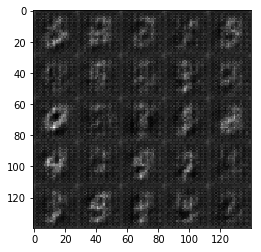

Batch: 110,  Generator Loss: 1.558, Discriminator Loss: 1.361
Batch: 120,  Generator Loss: 1.514, Discriminator Loss: 1.377
Batch: 130,  Generator Loss: 1.594, Discriminator Loss: 1.176
Batch: 140,  Generator Loss: 1.004, Discriminator Loss: 1.136
Batch: 150,  Generator Loss: 0.930, Discriminator Loss: 1.312
Batch: 160,  Generator Loss: 1.666, Discriminator Loss: 1.280
Batch: 170,  Generator Loss: 1.227, Discriminator Loss: 1.269
Batch: 180,  Generator Loss: 1.656, Discriminator Loss: 1.122
Batch: 190,  Generator Loss: 1.713, Discriminator Loss: 1.093
Batch: 200,  Generator Loss: 1.363, Discriminator Loss: 1.137


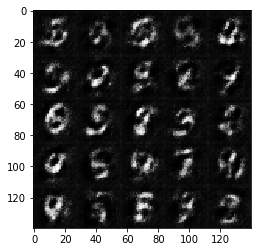

Batch: 210,  Generator Loss: 1.780, Discriminator Loss: 1.265
Batch: 220,  Generator Loss: 1.635, Discriminator Loss: 0.913
Batch: 230,  Generator Loss: 1.397, Discriminator Loss: 0.908
Batch: 240,  Generator Loss: 1.073, Discriminator Loss: 1.125
Batch: 250,  Generator Loss: 1.328, Discriminator Loss: 1.049
Batch: 260,  Generator Loss: 2.401, Discriminator Loss: 0.867
Batch: 270,  Generator Loss: 1.290, Discriminator Loss: 1.080
Batch: 280,  Generator Loss: 1.840, Discriminator Loss: 0.989
Batch: 290,  Generator Loss: 2.274, Discriminator Loss: 1.145
Batch: 300,  Generator Loss: 0.763, Discriminator Loss: 1.273


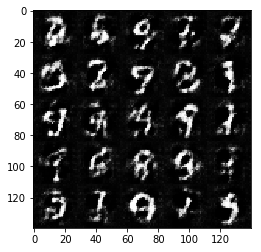

Batch: 310,  Generator Loss: 1.468, Discriminator Loss: 0.895
Batch: 320,  Generator Loss: 1.502, Discriminator Loss: 0.814
Batch: 330,  Generator Loss: 1.953, Discriminator Loss: 0.988
Batch: 340,  Generator Loss: 2.919, Discriminator Loss: 1.412
Batch: 350,  Generator Loss: 2.354, Discriminator Loss: 0.936
Batch: 360,  Generator Loss: 2.293, Discriminator Loss: 1.059
Batch: 370,  Generator Loss: 1.765, Discriminator Loss: 0.948
Batch: 380,  Generator Loss: 0.884, Discriminator Loss: 1.024
Batch: 390,  Generator Loss: 1.914, Discriminator Loss: 0.870
Batch: 400,  Generator Loss: 1.089, Discriminator Loss: 0.905


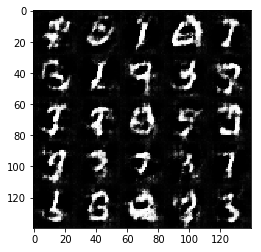

Batch: 410,  Generator Loss: 1.797, Discriminator Loss: 1.235
Batch: 420,  Generator Loss: 2.970, Discriminator Loss: 0.842
Batch: 430,  Generator Loss: 1.599, Discriminator Loss: 1.137
Batch: 440,  Generator Loss: 1.523, Discriminator Loss: 1.215
Batch: 450,  Generator Loss: 1.241, Discriminator Loss: 0.942
Batch: 460,  Generator Loss: 1.550, Discriminator Loss: 1.121
Batch: 470,  Generator Loss: 1.567, Discriminator Loss: 0.798
Batch: 480,  Generator Loss: 1.523, Discriminator Loss: 1.008
Batch: 490,  Generator Loss: 1.338, Discriminator Loss: 1.102
Batch: 500,  Generator Loss: 1.656, Discriminator Loss: 0.837


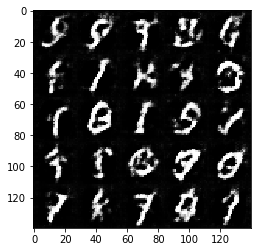

Batch: 510,  Generator Loss: 2.917, Discriminator Loss: 1.259
Batch: 520,  Generator Loss: 1.655, Discriminator Loss: 0.961
Batch: 530,  Generator Loss: 2.348, Discriminator Loss: 0.819
Batch: 540,  Generator Loss: 1.635, Discriminator Loss: 1.115
Batch: 550,  Generator Loss: 2.469, Discriminator Loss: 0.921
Batch: 560,  Generator Loss: 3.872, Discriminator Loss: 1.354
Batch: 570,  Generator Loss: 1.450, Discriminator Loss: 0.949
Batch: 580,  Generator Loss: 2.596, Discriminator Loss: 1.052
Batch: 590,  Generator Loss: 1.397, Discriminator Loss: 1.003
Batch: 600,  Generator Loss: 1.408, Discriminator Loss: 0.916


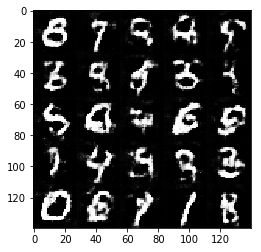

Batch: 610,  Generator Loss: 1.433, Discriminator Loss: 0.956
Batch: 620,  Generator Loss: 1.518, Discriminator Loss: 0.838
Batch: 630,  Generator Loss: 2.542, Discriminator Loss: 0.976
Batch: 640,  Generator Loss: 1.439, Discriminator Loss: 0.948
Batch: 650,  Generator Loss: 1.484, Discriminator Loss: 1.792
Batch: 660,  Generator Loss: 2.027, Discriminator Loss: 0.727
Batch: 670,  Generator Loss: 3.364, Discriminator Loss: 1.072
Batch: 680,  Generator Loss: 2.129, Discriminator Loss: 0.725
Batch: 690,  Generator Loss: 1.134, Discriminator Loss: 0.893
Batch: 700,  Generator Loss: 2.263, Discriminator Loss: 0.691


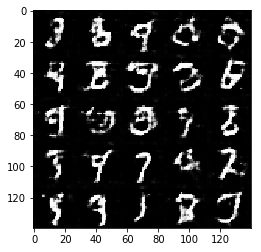

Batch: 710,  Generator Loss: 1.447, Discriminator Loss: 0.917
Batch: 720,  Generator Loss: 1.683, Discriminator Loss: 0.789
Batch: 730,  Generator Loss: 1.471, Discriminator Loss: 0.804
Batch: 740,  Generator Loss: 2.676, Discriminator Loss: 1.051
Batch: 750,  Generator Loss: 2.704, Discriminator Loss: 0.895
Batch: 760,  Generator Loss: 2.122, Discriminator Loss: 0.680
Batch: 770,  Generator Loss: 1.798, Discriminator Loss: 0.756
Batch: 780,  Generator Loss: 5.276, Discriminator Loss: 1.269
Batch: 790,  Generator Loss: 2.022, Discriminator Loss: 0.705
Batch: 800,  Generator Loss: 1.734, Discriminator Loss: 1.090


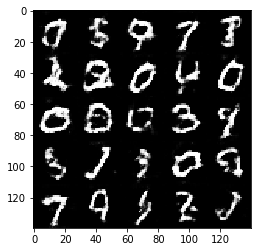

Batch: 810,  Generator Loss: 2.467, Discriminator Loss: 0.703
Batch: 820,  Generator Loss: 2.017, Discriminator Loss: 0.707
Batch: 830,  Generator Loss: 3.715, Discriminator Loss: 0.918
Batch: 840,  Generator Loss: 2.568, Discriminator Loss: 0.667
Batch: 850,  Generator Loss: 2.539, Discriminator Loss: 0.892
Batch: 860,  Generator Loss: 2.838, Discriminator Loss: 0.697
Batch: 870,  Generator Loss: 1.072, Discriminator Loss: 0.941
Batch: 880,  Generator Loss: 2.668, Discriminator Loss: 0.828
Batch: 890,  Generator Loss: 2.346, Discriminator Loss: 0.973
Batch: 900,  Generator Loss: 2.337, Discriminator Loss: 0.582


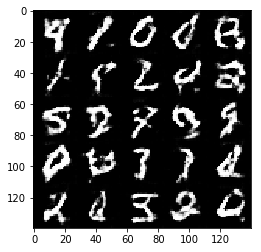

Batch: 910,  Generator Loss: 1.716, Discriminator Loss: 0.877
Batch: 920,  Generator Loss: 2.187, Discriminator Loss: 0.626
Batch: 930,  Generator Loss: 2.314, Discriminator Loss: 1.009
Batch: 940,  Generator Loss: 2.398, Discriminator Loss: 0.792
Batch: 950,  Generator Loss: 2.811, Discriminator Loss: 0.690
Batch: 960,  Generator Loss: 1.914, Discriminator Loss: 0.679
Batch: 970,  Generator Loss: 0.950, Discriminator Loss: 1.290
Batch: 980,  Generator Loss: 2.743, Discriminator Loss: 0.651
Batch: 990,  Generator Loss: 2.256, Discriminator Loss: 0.639
Batch: 1000,  Generator Loss: 2.342, Discriminator Loss: 0.643


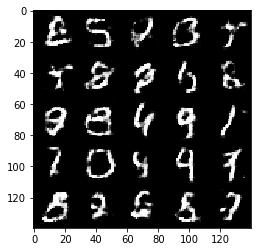

Batch: 1010,  Generator Loss: 1.956, Discriminator Loss: 0.698
Batch: 1020,  Generator Loss: 0.527, Discriminator Loss: 1.236
Batch: 1030,  Generator Loss: 1.913, Discriminator Loss: 0.969
Batch: 1040,  Generator Loss: 1.402, Discriminator Loss: 0.723
Batch: 1050,  Generator Loss: 2.961, Discriminator Loss: 0.624
Batch: 1060,  Generator Loss: 2.770, Discriminator Loss: 0.658
Batch: 1070,  Generator Loss: 3.036, Discriminator Loss: 0.737
Batch: 1080,  Generator Loss: 2.787, Discriminator Loss: 0.655
Batch: 1090,  Generator Loss: 2.239, Discriminator Loss: 0.625
Batch: 1100,  Generator Loss: 1.904, Discriminator Loss: 0.641


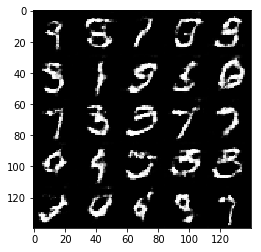

Batch: 1110,  Generator Loss: 2.714, Discriminator Loss: 0.696
Batch: 1120,  Generator Loss: 0.564, Discriminator Loss: 1.932
Batch: 1130,  Generator Loss: 2.182, Discriminator Loss: 0.853
Batch: 1140,  Generator Loss: 2.517, Discriminator Loss: 0.889
Batch: 1150,  Generator Loss: 2.216, Discriminator Loss: 0.916
Batch: 1160,  Generator Loss: 2.479, Discriminator Loss: 0.614
Batch: 1170,  Generator Loss: 1.897, Discriminator Loss: 0.683
Batch: 1180,  Generator Loss: 2.013, Discriminator Loss: 1.345
Batch: 1190,  Generator Loss: 2.287, Discriminator Loss: 0.840
Batch: 1200,  Generator Loss: 2.987, Discriminator Loss: 0.736


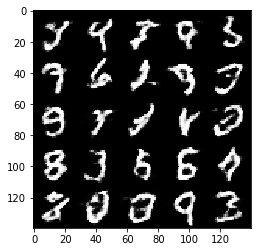

Batch: 1210,  Generator Loss: 1.979, Discriminator Loss: 0.723
Batch: 1220,  Generator Loss: 4.371, Discriminator Loss: 1.414
Batch: 1230,  Generator Loss: 2.339, Discriminator Loss: 0.996
Batch: 1240,  Generator Loss: 2.404, Discriminator Loss: 0.670
Batch: 1250,  Generator Loss: 2.659, Discriminator Loss: 0.635
Batch: 1260,  Generator Loss: 2.682, Discriminator Loss: 0.540
Batch: 1270,  Generator Loss: 1.907, Discriminator Loss: 0.691
Batch: 1280,  Generator Loss: 2.214, Discriminator Loss: 0.757
Batch: 1290,  Generator Loss: 1.624, Discriminator Loss: 0.879
Batch: 1300,  Generator Loss: 1.263, Discriminator Loss: 0.830


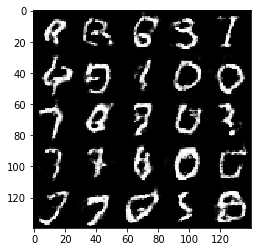

Batch: 1310,  Generator Loss: 3.101, Discriminator Loss: 0.598
Batch: 1320,  Generator Loss: 1.541, Discriminator Loss: 0.961
Batch: 1330,  Generator Loss: 2.071, Discriminator Loss: 0.705
Batch: 1340,  Generator Loss: 2.836, Discriminator Loss: 0.717
Batch: 1350,  Generator Loss: 0.619, Discriminator Loss: 1.406
Batch: 1360,  Generator Loss: 1.084, Discriminator Loss: 1.451
Batch: 1370,  Generator Loss: 1.990, Discriminator Loss: 0.741
Batch: 1380,  Generator Loss: 2.723, Discriminator Loss: 0.464
Batch: 1390,  Generator Loss: 3.335, Discriminator Loss: 0.710
Batch: 1400,  Generator Loss: 1.388, Discriminator Loss: 0.951


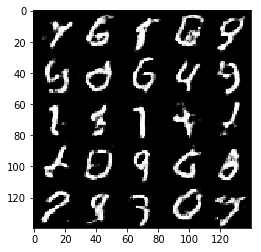

Batch: 1410,  Generator Loss: 2.309, Discriminator Loss: 0.675
Batch: 1420,  Generator Loss: 2.373, Discriminator Loss: 0.859
Batch: 1430,  Generator Loss: 2.537, Discriminator Loss: 0.769
Batch: 1440,  Generator Loss: 2.300, Discriminator Loss: 0.609
Batch: 1450,  Generator Loss: 2.823, Discriminator Loss: 0.564
Batch: 1460,  Generator Loss: 2.846, Discriminator Loss: 0.554
Batch: 1470,  Generator Loss: 0.780, Discriminator Loss: 1.291
Batch: 1480,  Generator Loss: 2.023, Discriminator Loss: 0.645
Batch: 1490,  Generator Loss: 1.868, Discriminator Loss: 0.692
Batch: 1500,  Generator Loss: 2.709, Discriminator Loss: 0.660


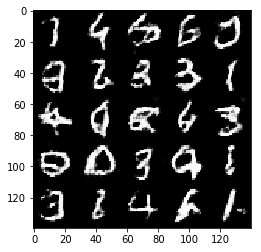

Batch: 1510,  Generator Loss: 1.503, Discriminator Loss: 0.822
Batch: 1520,  Generator Loss: 2.236, Discriminator Loss: 0.605
Batch: 1530,  Generator Loss: 2.111, Discriminator Loss: 0.726
Batch: 1540,  Generator Loss: 2.858, Discriminator Loss: 0.592
Batch: 1550,  Generator Loss: 2.360, Discriminator Loss: 0.691
Batch: 1560,  Generator Loss: 2.569, Discriminator Loss: 0.743
Batch: 1570,  Generator Loss: 2.796, Discriminator Loss: 0.873
Batch: 1580,  Generator Loss: 2.448, Discriminator Loss: 0.709
Batch: 1590,  Generator Loss: 2.747, Discriminator Loss: 0.649
Batch: 1600,  Generator Loss: 2.101, Discriminator Loss: 0.665


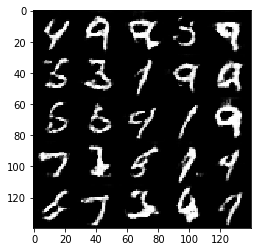

Batch: 1610,  Generator Loss: 1.910, Discriminator Loss: 0.847
Batch: 1620,  Generator Loss: 2.917, Discriminator Loss: 0.600
Batch: 1630,  Generator Loss: 1.906, Discriminator Loss: 0.664
Batch: 1640,  Generator Loss: 1.803, Discriminator Loss: 0.679
Batch: 1650,  Generator Loss: 2.723, Discriminator Loss: 0.575
Batch: 1660,  Generator Loss: 3.049, Discriminator Loss: 0.612
Batch: 1670,  Generator Loss: 1.715, Discriminator Loss: 0.683
Batch: 1680,  Generator Loss: 2.223, Discriminator Loss: 0.893
Batch: 1690,  Generator Loss: 3.441, Discriminator Loss: 1.126
Batch: 1700,  Generator Loss: 2.578, Discriminator Loss: 0.529


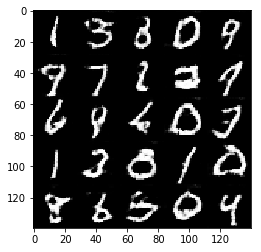

Batch: 1710,  Generator Loss: 2.649, Discriminator Loss: 0.539
Batch: 1720,  Generator Loss: 0.930, Discriminator Loss: 1.514
Batch: 1730,  Generator Loss: 1.708, Discriminator Loss: 0.864
Batch: 1740,  Generator Loss: 0.604, Discriminator Loss: 1.489
Batch: 1750,  Generator Loss: 2.404, Discriminator Loss: 0.775
Batch: 1760,  Generator Loss: 2.818, Discriminator Loss: 0.535
Batch: 1770,  Generator Loss: 0.603, Discriminator Loss: 1.497
Batch: 1780,  Generator Loss: 1.977, Discriminator Loss: 0.843
Batch: 1790,  Generator Loss: 2.630, Discriminator Loss: 0.598
Batch: 1800,  Generator Loss: 2.062, Discriminator Loss: 0.661


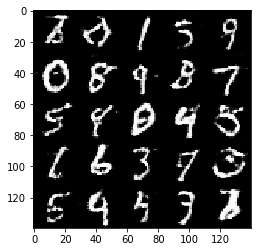

Batch: 1810,  Generator Loss: 1.528, Discriminator Loss: 0.787
Batch: 1820,  Generator Loss: 2.842, Discriminator Loss: 0.621
Batch: 1830,  Generator Loss: 2.304, Discriminator Loss: 0.911
Batch: 1840,  Generator Loss: 1.776, Discriminator Loss: 0.856
Batch: 1850,  Generator Loss: 2.627, Discriminator Loss: 0.580
Batch: 1860,  Generator Loss: 2.574, Discriminator Loss: 0.546
Batch: 1870,  Generator Loss: 2.990, Discriminator Loss: 0.582
Batch: 10,  Generator Loss: 1.304, Discriminator Loss: 1.084
Batch: 20,  Generator Loss: 1.344, Discriminator Loss: 0.933
Batch: 30,  Generator Loss: 1.586, Discriminator Loss: 0.774
Batch: 40,  Generator Loss: 2.283, Discriminator Loss: 0.707
Batch: 50,  Generator Loss: 3.184, Discriminator Loss: 0.681
Batch: 60,  Generator Loss: 2.079, Discriminator Loss: 1.372
Batch: 70,  Generator Loss: 2.107, Discriminator Loss: 0.787
Batch: 80,  Generator Loss: 2.712, Discriminator Loss: 0.609
Batch: 90,  Generator Loss: 2.603, Discriminator Loss: 0.535
Batch: 100

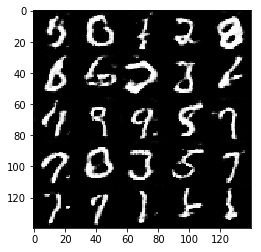

Batch: 110,  Generator Loss: 1.707, Discriminator Loss: 1.088
Batch: 120,  Generator Loss: 2.374, Discriminator Loss: 0.684
Batch: 130,  Generator Loss: 1.277, Discriminator Loss: 0.886
Batch: 140,  Generator Loss: 1.615, Discriminator Loss: 0.833
Batch: 150,  Generator Loss: 1.865, Discriminator Loss: 1.000
Batch: 160,  Generator Loss: 2.862, Discriminator Loss: 0.564
Batch: 170,  Generator Loss: 1.598, Discriminator Loss: 1.056
Batch: 180,  Generator Loss: 2.254, Discriminator Loss: 0.599
Batch: 190,  Generator Loss: 2.477, Discriminator Loss: 0.544
Batch: 200,  Generator Loss: 2.606, Discriminator Loss: 0.705


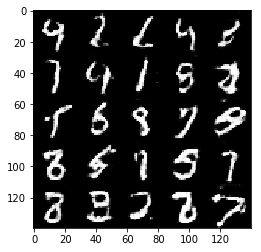

Batch: 210,  Generator Loss: 1.248, Discriminator Loss: 1.326
Batch: 220,  Generator Loss: 2.572, Discriminator Loss: 0.905
Batch: 230,  Generator Loss: 2.678, Discriminator Loss: 0.507
Batch: 240,  Generator Loss: 2.478, Discriminator Loss: 0.700
Batch: 250,  Generator Loss: 2.154, Discriminator Loss: 0.695
Batch: 260,  Generator Loss: 2.766, Discriminator Loss: 0.511
Batch: 270,  Generator Loss: 2.715, Discriminator Loss: 0.615
Batch: 280,  Generator Loss: 2.694, Discriminator Loss: 0.519
Batch: 290,  Generator Loss: 2.430, Discriminator Loss: 0.585
Batch: 300,  Generator Loss: 1.645, Discriminator Loss: 0.903


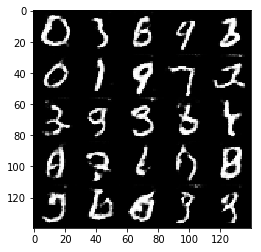

Batch: 310,  Generator Loss: 3.228, Discriminator Loss: 0.521
Batch: 320,  Generator Loss: 1.954, Discriminator Loss: 0.634
Batch: 330,  Generator Loss: 1.804, Discriminator Loss: 0.702
Batch: 340,  Generator Loss: 2.635, Discriminator Loss: 0.795
Batch: 350,  Generator Loss: 2.223, Discriminator Loss: 0.562
Batch: 360,  Generator Loss: 3.072, Discriminator Loss: 0.598
Batch: 370,  Generator Loss: 2.593, Discriminator Loss: 0.565
Batch: 380,  Generator Loss: 1.995, Discriminator Loss: 0.920
Batch: 390,  Generator Loss: 2.301, Discriminator Loss: 0.586
Batch: 400,  Generator Loss: 1.500, Discriminator Loss: 0.927


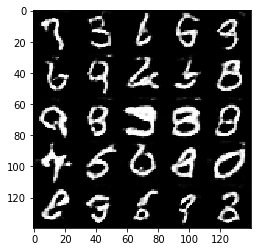

Batch: 410,  Generator Loss: 1.813, Discriminator Loss: 0.865
Batch: 420,  Generator Loss: 2.632, Discriminator Loss: 0.488
Batch: 430,  Generator Loss: 3.612, Discriminator Loss: 0.860
Batch: 440,  Generator Loss: 1.735, Discriminator Loss: 0.910
Batch: 450,  Generator Loss: 1.895, Discriminator Loss: 0.679
Batch: 460,  Generator Loss: 2.213, Discriminator Loss: 0.875
Batch: 470,  Generator Loss: 2.149, Discriminator Loss: 0.634
Batch: 480,  Generator Loss: 4.118, Discriminator Loss: 0.897
Batch: 490,  Generator Loss: 2.406, Discriminator Loss: 0.646
Batch: 500,  Generator Loss: 2.169, Discriminator Loss: 0.615


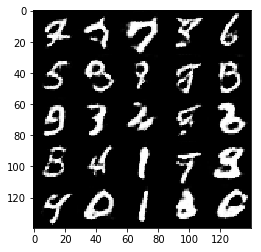

Batch: 510,  Generator Loss: 2.617, Discriminator Loss: 0.580
Batch: 520,  Generator Loss: 3.374, Discriminator Loss: 0.444
Batch: 530,  Generator Loss: 2.992, Discriminator Loss: 0.592
Batch: 540,  Generator Loss: 1.966, Discriminator Loss: 0.805
Batch: 550,  Generator Loss: 2.710, Discriminator Loss: 0.654
Batch: 560,  Generator Loss: 2.276, Discriminator Loss: 0.669
Batch: 570,  Generator Loss: 3.219, Discriminator Loss: 0.502
Batch: 580,  Generator Loss: 2.090, Discriminator Loss: 0.743
Batch: 590,  Generator Loss: 2.527, Discriminator Loss: 0.581
Batch: 600,  Generator Loss: 2.073, Discriminator Loss: 0.619


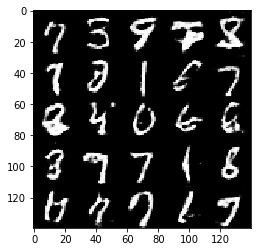

Batch: 610,  Generator Loss: 2.010, Discriminator Loss: 0.605
Batch: 620,  Generator Loss: 2.567, Discriminator Loss: 0.547
Batch: 630,  Generator Loss: 2.910, Discriminator Loss: 0.548
Batch: 640,  Generator Loss: 1.593, Discriminator Loss: 0.759
Batch: 650,  Generator Loss: 3.061, Discriminator Loss: 0.568
Batch: 660,  Generator Loss: 2.163, Discriminator Loss: 0.637
Batch: 670,  Generator Loss: 1.850, Discriminator Loss: 0.591
Batch: 680,  Generator Loss: 3.363, Discriminator Loss: 0.780
Batch: 690,  Generator Loss: 3.178, Discriminator Loss: 0.623
Batch: 700,  Generator Loss: 3.108, Discriminator Loss: 0.562


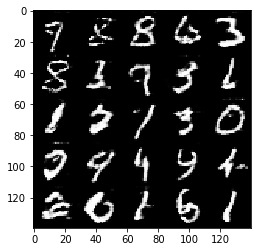

Batch: 710,  Generator Loss: 2.787, Discriminator Loss: 0.618
Batch: 720,  Generator Loss: 1.781, Discriminator Loss: 0.591
Batch: 730,  Generator Loss: 2.379, Discriminator Loss: 0.785
Batch: 740,  Generator Loss: 2.727, Discriminator Loss: 0.538
Batch: 750,  Generator Loss: 3.370, Discriminator Loss: 0.549
Batch: 760,  Generator Loss: 3.558, Discriminator Loss: 0.574
Batch: 770,  Generator Loss: 4.091, Discriminator Loss: 1.180
Batch: 780,  Generator Loss: 2.687, Discriminator Loss: 0.593
Batch: 790,  Generator Loss: 2.647, Discriminator Loss: 0.597
Batch: 800,  Generator Loss: 1.355, Discriminator Loss: 1.213


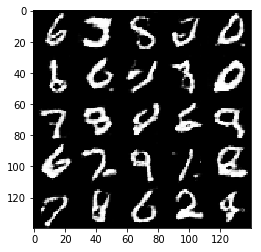

Batch: 810,  Generator Loss: 3.015, Discriminator Loss: 0.492
Batch: 820,  Generator Loss: 1.921, Discriminator Loss: 0.794
Batch: 830,  Generator Loss: 1.671, Discriminator Loss: 0.712
Batch: 840,  Generator Loss: 3.064, Discriminator Loss: 0.551
Batch: 850,  Generator Loss: 2.839, Discriminator Loss: 0.559
Batch: 860,  Generator Loss: 2.289, Discriminator Loss: 0.665
Batch: 870,  Generator Loss: 2.965, Discriminator Loss: 0.859
Batch: 880,  Generator Loss: 1.417, Discriminator Loss: 0.744
Batch: 890,  Generator Loss: 2.475, Discriminator Loss: 0.495
Batch: 900,  Generator Loss: 2.773, Discriminator Loss: 0.500


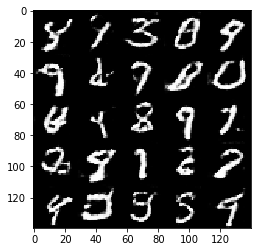

Batch: 910,  Generator Loss: 3.230, Discriminator Loss: 0.546
Batch: 920,  Generator Loss: 2.865, Discriminator Loss: 0.524
Batch: 930,  Generator Loss: 1.543, Discriminator Loss: 0.730
Batch: 940,  Generator Loss: 0.906, Discriminator Loss: 0.889
Batch: 950,  Generator Loss: 3.045, Discriminator Loss: 0.554
Batch: 960,  Generator Loss: 2.716, Discriminator Loss: 0.663
Batch: 970,  Generator Loss: 2.788, Discriminator Loss: 0.484
Batch: 980,  Generator Loss: 2.799, Discriminator Loss: 0.498
Batch: 990,  Generator Loss: 2.350, Discriminator Loss: 0.608
Batch: 1000,  Generator Loss: 1.933, Discriminator Loss: 0.691


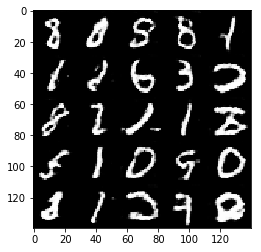

Batch: 1010,  Generator Loss: 2.052, Discriminator Loss: 0.607
Batch: 1020,  Generator Loss: 3.130, Discriminator Loss: 0.601
Batch: 1030,  Generator Loss: 2.382, Discriminator Loss: 0.615
Batch: 1040,  Generator Loss: 2.971, Discriminator Loss: 0.534
Batch: 1050,  Generator Loss: 2.232, Discriminator Loss: 0.597
Batch: 1060,  Generator Loss: 2.711, Discriminator Loss: 0.660
Batch: 1070,  Generator Loss: 1.022, Discriminator Loss: 0.820
Batch: 1080,  Generator Loss: 1.797, Discriminator Loss: 0.699
Batch: 1090,  Generator Loss: 2.505, Discriminator Loss: 0.596
Batch: 1100,  Generator Loss: 3.121, Discriminator Loss: 0.502


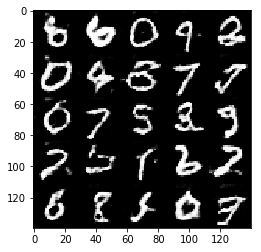

Batch: 1110,  Generator Loss: 1.162, Discriminator Loss: 2.479
Batch: 1120,  Generator Loss: 1.821, Discriminator Loss: 0.895
Batch: 1130,  Generator Loss: 2.164, Discriminator Loss: 0.613
Batch: 1140,  Generator Loss: 2.257, Discriminator Loss: 0.663
Batch: 1150,  Generator Loss: 2.607, Discriminator Loss: 0.698
Batch: 1160,  Generator Loss: 2.883, Discriminator Loss: 0.482
Batch: 1170,  Generator Loss: 2.859, Discriminator Loss: 0.536
Batch: 1180,  Generator Loss: 2.702, Discriminator Loss: 0.577
Batch: 1190,  Generator Loss: 2.534, Discriminator Loss: 0.627
Batch: 1200,  Generator Loss: 2.226, Discriminator Loss: 0.611


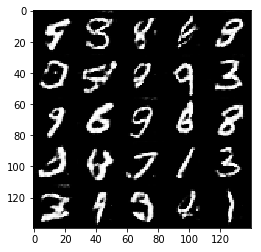

Batch: 1210,  Generator Loss: 3.227, Discriminator Loss: 0.481
Batch: 1220,  Generator Loss: 4.014, Discriminator Loss: 0.880
Batch: 1230,  Generator Loss: 2.875, Discriminator Loss: 0.507
Batch: 1240,  Generator Loss: 2.919, Discriminator Loss: 0.497
Batch: 1250,  Generator Loss: 2.415, Discriminator Loss: 0.565
Batch: 1260,  Generator Loss: 3.693, Discriminator Loss: 0.507
Batch: 1270,  Generator Loss: 1.760, Discriminator Loss: 0.705
Batch: 1280,  Generator Loss: 3.054, Discriminator Loss: 0.532
Batch: 1290,  Generator Loss: 2.613, Discriminator Loss: 0.648
Batch: 1300,  Generator Loss: 3.087, Discriminator Loss: 0.660


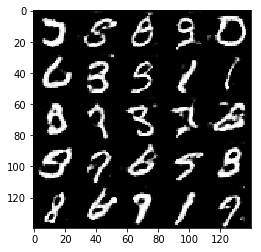

Batch: 1310,  Generator Loss: 3.856, Discriminator Loss: 0.433
Batch: 1320,  Generator Loss: 2.378, Discriminator Loss: 0.544
Batch: 1330,  Generator Loss: 2.104, Discriminator Loss: 0.870
Batch: 1340,  Generator Loss: 5.256, Discriminator Loss: 2.761
Batch: 1350,  Generator Loss: 2.512, Discriminator Loss: 0.656
Batch: 1360,  Generator Loss: 2.063, Discriminator Loss: 0.901
Batch: 1370,  Generator Loss: 2.494, Discriminator Loss: 0.550
Batch: 1380,  Generator Loss: 3.756, Discriminator Loss: 0.399
Batch: 1390,  Generator Loss: 2.672, Discriminator Loss: 0.569
Batch: 1400,  Generator Loss: 2.521, Discriminator Loss: 0.604


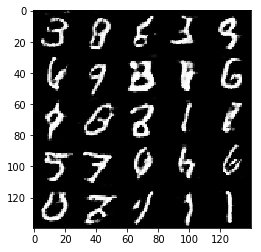

Batch: 1410,  Generator Loss: 2.846, Discriminator Loss: 0.565
Batch: 1420,  Generator Loss: 5.151, Discriminator Loss: 0.886
Batch: 1430,  Generator Loss: 2.978, Discriminator Loss: 1.091
Batch: 1440,  Generator Loss: 2.645, Discriminator Loss: 0.720
Batch: 1450,  Generator Loss: 2.806, Discriminator Loss: 0.546
Batch: 1460,  Generator Loss: 3.774, Discriminator Loss: 0.751
Batch: 1470,  Generator Loss: 2.621, Discriminator Loss: 0.545
Batch: 1480,  Generator Loss: 2.645, Discriminator Loss: 0.499
Batch: 1490,  Generator Loss: 2.931, Discriminator Loss: 0.526
Batch: 1500,  Generator Loss: 3.633, Discriminator Loss: 0.536


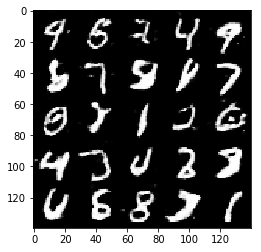

Batch: 1510,  Generator Loss: 1.471, Discriminator Loss: 0.734
Batch: 1520,  Generator Loss: 2.590, Discriminator Loss: 0.503
Batch: 1530,  Generator Loss: 2.165, Discriminator Loss: 0.643
Batch: 1540,  Generator Loss: 2.831, Discriminator Loss: 0.485
Batch: 1550,  Generator Loss: 3.171, Discriminator Loss: 0.532
Batch: 1560,  Generator Loss: 3.284, Discriminator Loss: 1.069
Batch: 1570,  Generator Loss: 2.707, Discriminator Loss: 0.861
Batch: 1580,  Generator Loss: 2.167, Discriminator Loss: 0.593
Batch: 1590,  Generator Loss: 3.254, Discriminator Loss: 0.531
Batch: 1600,  Generator Loss: 2.336, Discriminator Loss: 0.604


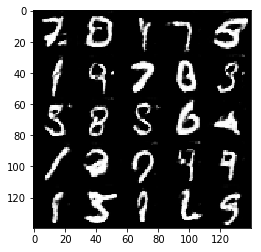

Batch: 1610,  Generator Loss: 2.373, Discriminator Loss: 0.653
Batch: 1620,  Generator Loss: 2.220, Discriminator Loss: 0.669
Batch: 1630,  Generator Loss: 3.040, Discriminator Loss: 0.462
Batch: 1640,  Generator Loss: 2.816, Discriminator Loss: 0.519
Batch: 1650,  Generator Loss: 5.554, Discriminator Loss: 1.269
Batch: 1660,  Generator Loss: 3.251, Discriminator Loss: 0.597
Batch: 1670,  Generator Loss: 1.430, Discriminator Loss: 0.880
Batch: 1680,  Generator Loss: 3.467, Discriminator Loss: 0.499
Batch: 1690,  Generator Loss: 3.667, Discriminator Loss: 0.808
Batch: 1700,  Generator Loss: 3.031, Discriminator Loss: 0.478


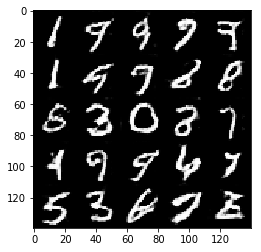

Batch: 1710,  Generator Loss: 2.982, Discriminator Loss: 0.535
Batch: 1720,  Generator Loss: 3.628, Discriminator Loss: 0.983
Batch: 1730,  Generator Loss: 6.139, Discriminator Loss: 3.108
Batch: 1740,  Generator Loss: 1.226, Discriminator Loss: 1.188
Batch: 1750,  Generator Loss: 3.474, Discriminator Loss: 0.791
Batch: 1760,  Generator Loss: 3.003, Discriminator Loss: 0.559
Batch: 1770,  Generator Loss: 2.957, Discriminator Loss: 0.525
Batch: 1780,  Generator Loss: 2.042, Discriminator Loss: 0.663
Batch: 1790,  Generator Loss: 3.130, Discriminator Loss: 0.478
Batch: 1800,  Generator Loss: 2.460, Discriminator Loss: 0.536


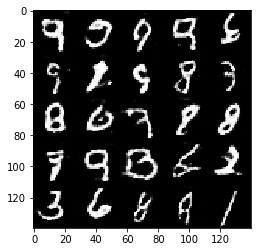

Batch: 1810,  Generator Loss: 1.604, Discriminator Loss: 0.966
Batch: 1820,  Generator Loss: 3.155, Discriminator Loss: 0.503
Batch: 1830,  Generator Loss: 2.224, Discriminator Loss: 0.810
Batch: 1840,  Generator Loss: 1.691, Discriminator Loss: 0.719
Batch: 1850,  Generator Loss: 3.017, Discriminator Loss: 0.588
Batch: 1860,  Generator Loss: 3.454, Discriminator Loss: 0.657
Batch: 1870,  Generator Loss: 3.574, Discriminator Loss: 0.421
Model trained and saved


In [13]:
batch_size = 32
z_dim = 50
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Batch: 10,  Generator Loss: 4.251, Discriminator Loss: 1.795
Batch: 20,  Generator Loss: 4.210, Discriminator Loss: 1.014
Batch: 30,  Generator Loss: 4.796, Discriminator Loss: 1.119
Batch: 40,  Generator Loss: 6.960, Discriminator Loss: 1.086
Batch: 50,  Generator Loss: 4.569, Discriminator Loss: 1.082
Batch: 60,  Generator Loss: 7.444, Discriminator Loss: 1.841
Batch: 70,  Generator Loss: 5.902, Discriminator Loss: 1.081
Batch: 80,  Generator Loss: 4.789, Discriminator Loss: 0.850
Batch: 90,  Generator Loss: 4.182, Discriminator Loss: 0.785
Batch: 100,  Generator Loss: 2.636, Discriminator Loss: 1.175


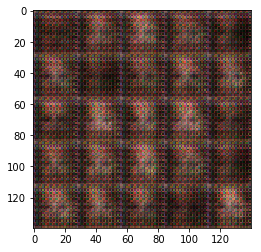

Batch: 110,  Generator Loss: 1.892, Discriminator Loss: 1.062
Batch: 120,  Generator Loss: 1.176, Discriminator Loss: 1.318
Batch: 130,  Generator Loss: 2.055, Discriminator Loss: 1.286
Batch: 140,  Generator Loss: 3.857, Discriminator Loss: 1.413
Batch: 150,  Generator Loss: 2.810, Discriminator Loss: 1.151
Batch: 160,  Generator Loss: 1.768, Discriminator Loss: 1.185
Batch: 170,  Generator Loss: 1.755, Discriminator Loss: 1.251
Batch: 180,  Generator Loss: 1.324, Discriminator Loss: 1.188
Batch: 190,  Generator Loss: 2.112, Discriminator Loss: 1.136
Batch: 200,  Generator Loss: 2.240, Discriminator Loss: 1.285


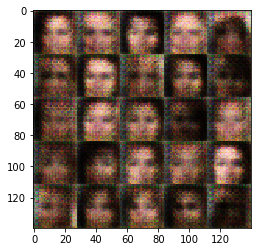

Batch: 210,  Generator Loss: 2.846, Discriminator Loss: 1.165
Batch: 220,  Generator Loss: 2.640, Discriminator Loss: 1.013
Batch: 230,  Generator Loss: 2.161, Discriminator Loss: 1.323
Batch: 240,  Generator Loss: 2.978, Discriminator Loss: 1.721
Batch: 250,  Generator Loss: 1.843, Discriminator Loss: 1.070
Batch: 260,  Generator Loss: 1.320, Discriminator Loss: 1.110
Batch: 270,  Generator Loss: 1.392, Discriminator Loss: 1.017
Batch: 280,  Generator Loss: 2.060, Discriminator Loss: 1.260
Batch: 290,  Generator Loss: 1.171, Discriminator Loss: 1.439
Batch: 300,  Generator Loss: 1.941, Discriminator Loss: 1.293


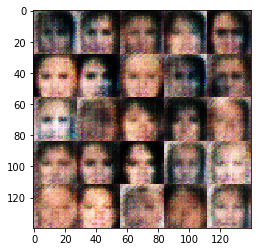

Batch: 310,  Generator Loss: 1.054, Discriminator Loss: 1.261
Batch: 320,  Generator Loss: 2.512, Discriminator Loss: 1.303
Batch: 330,  Generator Loss: 1.740, Discriminator Loss: 1.142
Batch: 340,  Generator Loss: 1.763, Discriminator Loss: 1.103
Batch: 350,  Generator Loss: 0.902, Discriminator Loss: 1.241
Batch: 360,  Generator Loss: 2.644, Discriminator Loss: 1.322
Batch: 370,  Generator Loss: 2.279, Discriminator Loss: 1.437
Batch: 380,  Generator Loss: 1.671, Discriminator Loss: 0.964
Batch: 390,  Generator Loss: 2.064, Discriminator Loss: 1.341
Batch: 400,  Generator Loss: 1.879, Discriminator Loss: 1.166


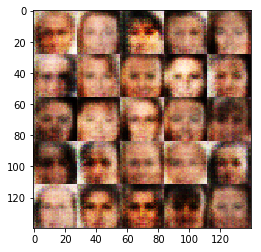

Batch: 410,  Generator Loss: 1.114, Discriminator Loss: 1.341
Batch: 420,  Generator Loss: 1.033, Discriminator Loss: 1.324
Batch: 430,  Generator Loss: 1.016, Discriminator Loss: 1.633
Batch: 440,  Generator Loss: 1.702, Discriminator Loss: 1.428
Batch: 450,  Generator Loss: 1.569, Discriminator Loss: 1.222
Batch: 460,  Generator Loss: 0.867, Discriminator Loss: 1.448
Batch: 470,  Generator Loss: 1.845, Discriminator Loss: 1.410
Batch: 480,  Generator Loss: 1.789, Discriminator Loss: 1.297
Batch: 490,  Generator Loss: 1.611, Discriminator Loss: 1.573
Batch: 500,  Generator Loss: 1.181, Discriminator Loss: 1.370


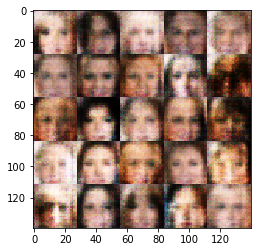

Batch: 510,  Generator Loss: 1.938, Discriminator Loss: 1.323
Batch: 520,  Generator Loss: 1.415, Discriminator Loss: 1.306
Batch: 530,  Generator Loss: 1.563, Discriminator Loss: 1.459
Batch: 540,  Generator Loss: 1.117, Discriminator Loss: 1.302
Batch: 550,  Generator Loss: 1.255, Discriminator Loss: 1.527
Batch: 560,  Generator Loss: 1.131, Discriminator Loss: 1.530
Batch: 570,  Generator Loss: 1.998, Discriminator Loss: 1.127
Batch: 580,  Generator Loss: 1.238, Discriminator Loss: 1.436
Batch: 590,  Generator Loss: 1.354, Discriminator Loss: 1.261
Batch: 600,  Generator Loss: 1.354, Discriminator Loss: 1.432


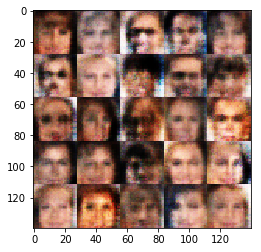

Batch: 610,  Generator Loss: 0.891, Discriminator Loss: 1.420
Batch: 620,  Generator Loss: 1.194, Discriminator Loss: 1.344
Batch: 630,  Generator Loss: 1.207, Discriminator Loss: 1.193
Batch: 640,  Generator Loss: 0.986, Discriminator Loss: 1.556
Batch: 650,  Generator Loss: 1.489, Discriminator Loss: 1.440
Batch: 660,  Generator Loss: 0.902, Discriminator Loss: 1.439
Batch: 670,  Generator Loss: 1.662, Discriminator Loss: 1.323
Batch: 680,  Generator Loss: 1.289, Discriminator Loss: 1.437
Batch: 690,  Generator Loss: 1.167, Discriminator Loss: 1.246
Batch: 700,  Generator Loss: 1.534, Discriminator Loss: 1.339


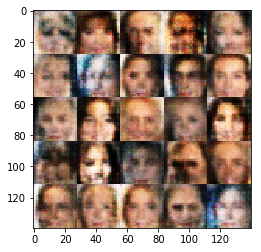

Batch: 710,  Generator Loss: 1.615, Discriminator Loss: 1.264
Batch: 720,  Generator Loss: 1.154, Discriminator Loss: 1.365
Batch: 730,  Generator Loss: 1.050, Discriminator Loss: 1.289
Batch: 740,  Generator Loss: 1.484, Discriminator Loss: 1.414
Batch: 750,  Generator Loss: 1.399, Discriminator Loss: 1.227
Batch: 760,  Generator Loss: 1.123, Discriminator Loss: 1.379
Batch: 770,  Generator Loss: 1.477, Discriminator Loss: 1.270
Batch: 780,  Generator Loss: 0.908, Discriminator Loss: 1.357
Batch: 790,  Generator Loss: 1.216, Discriminator Loss: 1.231
Batch: 800,  Generator Loss: 1.001, Discriminator Loss: 1.437


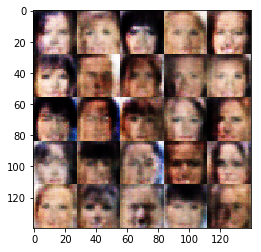

Batch: 810,  Generator Loss: 1.270, Discriminator Loss: 1.329
Batch: 820,  Generator Loss: 1.209, Discriminator Loss: 1.372
Batch: 830,  Generator Loss: 1.071, Discriminator Loss: 1.408
Batch: 840,  Generator Loss: 1.134, Discriminator Loss: 1.270
Batch: 850,  Generator Loss: 0.934, Discriminator Loss: 1.405
Batch: 860,  Generator Loss: 1.398, Discriminator Loss: 1.334
Batch: 870,  Generator Loss: 0.898, Discriminator Loss: 1.292
Batch: 880,  Generator Loss: 1.103, Discriminator Loss: 1.403
Batch: 890,  Generator Loss: 1.505, Discriminator Loss: 1.356
Batch: 900,  Generator Loss: 1.332, Discriminator Loss: 1.253


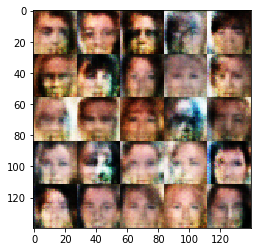

Batch: 910,  Generator Loss: 1.544, Discriminator Loss: 1.292
Batch: 920,  Generator Loss: 1.361, Discriminator Loss: 1.277
Batch: 930,  Generator Loss: 0.948, Discriminator Loss: 1.409
Batch: 940,  Generator Loss: 1.342, Discriminator Loss: 1.409
Batch: 950,  Generator Loss: 1.391, Discriminator Loss: 1.317
Batch: 960,  Generator Loss: 1.226, Discriminator Loss: 1.371
Batch: 970,  Generator Loss: 1.132, Discriminator Loss: 1.352
Batch: 980,  Generator Loss: 0.905, Discriminator Loss: 1.294
Batch: 990,  Generator Loss: 1.662, Discriminator Loss: 1.474
Batch: 1000,  Generator Loss: 1.018, Discriminator Loss: 1.419


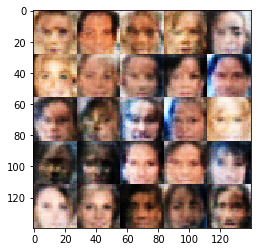

Batch: 1010,  Generator Loss: 1.498, Discriminator Loss: 1.460
Batch: 1020,  Generator Loss: 1.788, Discriminator Loss: 1.451
Batch: 1030,  Generator Loss: 1.119, Discriminator Loss: 1.467
Batch: 1040,  Generator Loss: 0.938, Discriminator Loss: 1.439
Batch: 1050,  Generator Loss: 1.434, Discriminator Loss: 1.237
Batch: 1060,  Generator Loss: 1.134, Discriminator Loss: 1.377
Batch: 1070,  Generator Loss: 1.751, Discriminator Loss: 1.532
Batch: 1080,  Generator Loss: 1.294, Discriminator Loss: 1.365
Batch: 1090,  Generator Loss: 1.160, Discriminator Loss: 1.307
Batch: 1100,  Generator Loss: 0.945, Discriminator Loss: 1.397


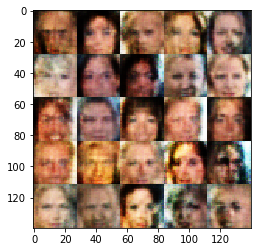

Batch: 1110,  Generator Loss: 1.161, Discriminator Loss: 1.185
Batch: 1120,  Generator Loss: 1.270, Discriminator Loss: 1.305
Batch: 1130,  Generator Loss: 1.445, Discriminator Loss: 1.432
Batch: 1140,  Generator Loss: 0.896, Discriminator Loss: 1.450
Batch: 1150,  Generator Loss: 0.917, Discriminator Loss: 1.340
Batch: 1160,  Generator Loss: 1.435, Discriminator Loss: 1.262
Batch: 1170,  Generator Loss: 1.159, Discriminator Loss: 1.347
Batch: 1180,  Generator Loss: 1.241, Discriminator Loss: 1.420
Batch: 1190,  Generator Loss: 1.518, Discriminator Loss: 1.392
Batch: 1200,  Generator Loss: 1.435, Discriminator Loss: 1.142


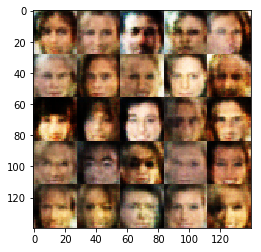

Batch: 1210,  Generator Loss: 1.502, Discriminator Loss: 1.184
Batch: 1220,  Generator Loss: 1.885, Discriminator Loss: 1.572
Batch: 1230,  Generator Loss: 1.635, Discriminator Loss: 1.313
Batch: 1240,  Generator Loss: 0.839, Discriminator Loss: 1.399
Batch: 1250,  Generator Loss: 0.939, Discriminator Loss: 1.307
Batch: 1260,  Generator Loss: 1.224, Discriminator Loss: 1.328
Batch: 1270,  Generator Loss: 1.537, Discriminator Loss: 1.217
Batch: 1280,  Generator Loss: 1.182, Discriminator Loss: 1.499
Batch: 1290,  Generator Loss: 1.018, Discriminator Loss: 1.322
Batch: 1300,  Generator Loss: 1.475, Discriminator Loss: 1.341


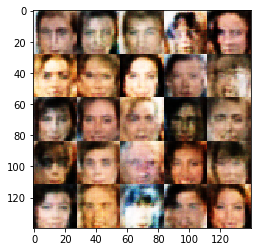

Batch: 1310,  Generator Loss: 0.848, Discriminator Loss: 1.438
Batch: 1320,  Generator Loss: 1.390, Discriminator Loss: 1.281
Batch: 1330,  Generator Loss: 1.091, Discriminator Loss: 1.260
Batch: 1340,  Generator Loss: 2.231, Discriminator Loss: 1.561
Batch: 1350,  Generator Loss: 1.557, Discriminator Loss: 1.210
Batch: 1360,  Generator Loss: 1.046, Discriminator Loss: 1.438
Batch: 1370,  Generator Loss: 0.962, Discriminator Loss: 1.630
Batch: 1380,  Generator Loss: 1.577, Discriminator Loss: 1.296
Batch: 1390,  Generator Loss: 1.375, Discriminator Loss: 1.205
Batch: 1400,  Generator Loss: 1.401, Discriminator Loss: 1.176


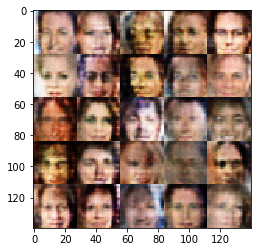

Batch: 1410,  Generator Loss: 1.385, Discriminator Loss: 1.215
Batch: 1420,  Generator Loss: 1.214, Discriminator Loss: 1.347
Batch: 1430,  Generator Loss: 1.333, Discriminator Loss: 1.054
Batch: 1440,  Generator Loss: 1.750, Discriminator Loss: 1.188
Batch: 1450,  Generator Loss: 1.379, Discriminator Loss: 1.119
Batch: 1460,  Generator Loss: 2.555, Discriminator Loss: 1.758
Batch: 1470,  Generator Loss: 1.068, Discriminator Loss: 1.428
Batch: 1480,  Generator Loss: 1.314, Discriminator Loss: 1.109
Batch: 1490,  Generator Loss: 0.781, Discriminator Loss: 1.333
Batch: 1500,  Generator Loss: 1.205, Discriminator Loss: 1.234


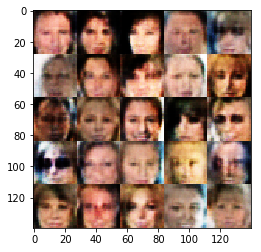

Batch: 1510,  Generator Loss: 0.960, Discriminator Loss: 1.204
Batch: 1520,  Generator Loss: 1.121, Discriminator Loss: 1.077
Batch: 1530,  Generator Loss: 1.600, Discriminator Loss: 1.544
Batch: 1540,  Generator Loss: 1.433, Discriminator Loss: 1.064
Batch: 1550,  Generator Loss: 1.245, Discriminator Loss: 1.138
Batch: 1560,  Generator Loss: 1.404, Discriminator Loss: 1.335
Batch: 1570,  Generator Loss: 0.916, Discriminator Loss: 1.467
Batch: 1580,  Generator Loss: 1.351, Discriminator Loss: 1.224
Batch: 1590,  Generator Loss: 1.146, Discriminator Loss: 1.232
Batch: 1600,  Generator Loss: 1.035, Discriminator Loss: 1.122


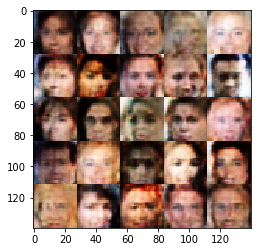

Batch: 1610,  Generator Loss: 1.024, Discriminator Loss: 1.322
Batch: 1620,  Generator Loss: 1.897, Discriminator Loss: 1.243
Batch: 1630,  Generator Loss: 1.201, Discriminator Loss: 1.066
Batch: 1640,  Generator Loss: 1.174, Discriminator Loss: 1.295
Batch: 1650,  Generator Loss: 1.160, Discriminator Loss: 1.060
Batch: 1660,  Generator Loss: 1.460, Discriminator Loss: 1.204
Batch: 1670,  Generator Loss: 1.069, Discriminator Loss: 1.442
Batch: 1680,  Generator Loss: 0.979, Discriminator Loss: 1.402
Batch: 1690,  Generator Loss: 1.908, Discriminator Loss: 1.435
Batch: 1700,  Generator Loss: 1.118, Discriminator Loss: 1.171


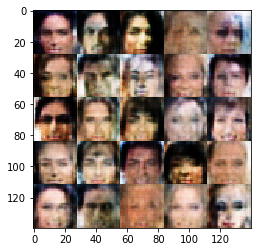

Batch: 1710,  Generator Loss: 1.314, Discriminator Loss: 1.302
Batch: 1720,  Generator Loss: 1.895, Discriminator Loss: 1.148
Batch: 1730,  Generator Loss: 1.444, Discriminator Loss: 1.109
Batch: 1740,  Generator Loss: 1.784, Discriminator Loss: 1.382
Batch: 1750,  Generator Loss: 2.466, Discriminator Loss: 1.945
Batch: 1760,  Generator Loss: 1.616, Discriminator Loss: 1.437
Batch: 1770,  Generator Loss: 1.303, Discriminator Loss: 1.221
Batch: 1780,  Generator Loss: 1.821, Discriminator Loss: 1.219
Batch: 1790,  Generator Loss: 1.845, Discriminator Loss: 1.350
Batch: 1800,  Generator Loss: 1.124, Discriminator Loss: 1.278


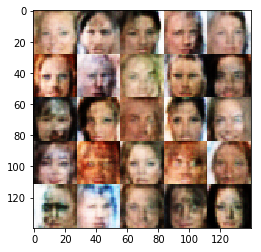

Batch: 1810,  Generator Loss: 1.099, Discriminator Loss: 1.160
Batch: 1820,  Generator Loss: 1.767, Discriminator Loss: 1.280
Batch: 1830,  Generator Loss: 2.720, Discriminator Loss: 1.587
Batch: 1840,  Generator Loss: 1.457, Discriminator Loss: 1.306
Batch: 1850,  Generator Loss: 1.222, Discriminator Loss: 1.196
Batch: 1860,  Generator Loss: 1.500, Discriminator Loss: 1.328
Batch: 1870,  Generator Loss: 1.271, Discriminator Loss: 1.036
Batch: 1880,  Generator Loss: 1.379, Discriminator Loss: 1.204
Batch: 1890,  Generator Loss: 1.666, Discriminator Loss: 0.925
Batch: 1900,  Generator Loss: 1.237, Discriminator Loss: 1.267


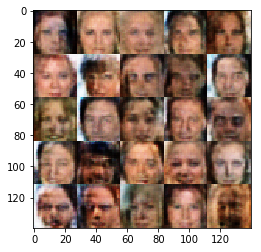

Batch: 1910,  Generator Loss: 2.525, Discriminator Loss: 1.275
Batch: 1920,  Generator Loss: 2.009, Discriminator Loss: 1.409
Batch: 1930,  Generator Loss: 1.486, Discriminator Loss: 1.078
Batch: 1940,  Generator Loss: 2.062, Discriminator Loss: 1.038
Batch: 1950,  Generator Loss: 1.149, Discriminator Loss: 1.232
Batch: 1960,  Generator Loss: 1.303, Discriminator Loss: 1.181
Batch: 1970,  Generator Loss: 1.447, Discriminator Loss: 1.177
Batch: 1980,  Generator Loss: 1.491, Discriminator Loss: 1.102
Batch: 1990,  Generator Loss: 2.139, Discriminator Loss: 0.965
Batch: 2000,  Generator Loss: 1.896, Discriminator Loss: 0.864


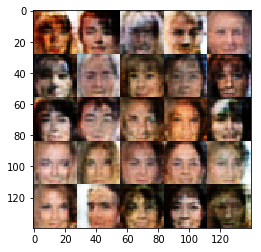

Batch: 2010,  Generator Loss: 1.778, Discriminator Loss: 1.120
Batch: 2020,  Generator Loss: 1.377, Discriminator Loss: 1.173
Batch: 2030,  Generator Loss: 1.744, Discriminator Loss: 1.123
Batch: 2040,  Generator Loss: 1.624, Discriminator Loss: 1.243
Batch: 2050,  Generator Loss: 1.080, Discriminator Loss: 1.159
Batch: 2060,  Generator Loss: 1.430, Discriminator Loss: 1.217
Batch: 2070,  Generator Loss: 1.452, Discriminator Loss: 1.210
Batch: 2080,  Generator Loss: 2.042, Discriminator Loss: 1.496
Batch: 2090,  Generator Loss: 1.249, Discriminator Loss: 1.410
Batch: 2100,  Generator Loss: 1.249, Discriminator Loss: 1.103


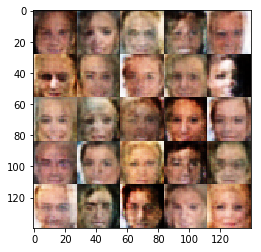

Batch: 2110,  Generator Loss: 1.598, Discriminator Loss: 1.065
Batch: 2120,  Generator Loss: 1.871, Discriminator Loss: 1.090
Batch: 2130,  Generator Loss: 2.178, Discriminator Loss: 1.220
Batch: 2140,  Generator Loss: 1.225, Discriminator Loss: 1.092
Batch: 2150,  Generator Loss: 2.014, Discriminator Loss: 1.476
Batch: 2160,  Generator Loss: 0.974, Discriminator Loss: 1.182
Batch: 2170,  Generator Loss: 0.743, Discriminator Loss: 1.352
Batch: 2180,  Generator Loss: 0.745, Discriminator Loss: 1.768
Batch: 2190,  Generator Loss: 0.922, Discriminator Loss: 1.264
Batch: 2200,  Generator Loss: 0.999, Discriminator Loss: 1.230


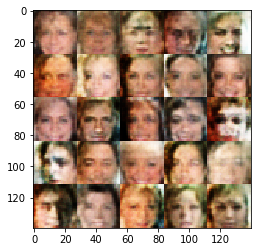

Batch: 2210,  Generator Loss: 1.082, Discriminator Loss: 1.264
Batch: 2220,  Generator Loss: 1.413, Discriminator Loss: 1.307
Batch: 2230,  Generator Loss: 1.899, Discriminator Loss: 1.586
Batch: 2240,  Generator Loss: 1.219, Discriminator Loss: 1.150
Batch: 2250,  Generator Loss: 1.222, Discriminator Loss: 1.142
Batch: 2260,  Generator Loss: 1.160, Discriminator Loss: 1.189
Batch: 2270,  Generator Loss: 1.287, Discriminator Loss: 1.026
Batch: 2280,  Generator Loss: 2.268, Discriminator Loss: 1.659
Batch: 2290,  Generator Loss: 2.100, Discriminator Loss: 1.536
Batch: 2300,  Generator Loss: 2.506, Discriminator Loss: 1.742


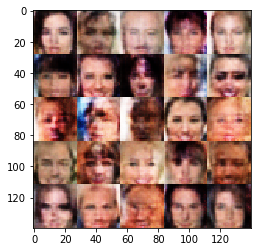

Batch: 2310,  Generator Loss: 1.498, Discriminator Loss: 1.181
Batch: 2320,  Generator Loss: 1.492, Discriminator Loss: 1.261
Batch: 2330,  Generator Loss: 1.021, Discriminator Loss: 1.172
Batch: 2340,  Generator Loss: 2.164, Discriminator Loss: 1.273
Batch: 2350,  Generator Loss: 1.342, Discriminator Loss: 1.141
Batch: 2360,  Generator Loss: 1.099, Discriminator Loss: 1.348
Batch: 2370,  Generator Loss: 1.676, Discriminator Loss: 1.663
Batch: 2380,  Generator Loss: 2.473, Discriminator Loss: 1.434
Batch: 2390,  Generator Loss: 1.387, Discriminator Loss: 1.171
Batch: 2400,  Generator Loss: 2.084, Discriminator Loss: 1.238


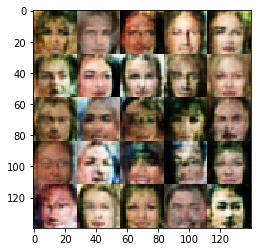

Batch: 2410,  Generator Loss: 1.202, Discriminator Loss: 1.163
Batch: 2420,  Generator Loss: 1.196, Discriminator Loss: 1.266
Batch: 2430,  Generator Loss: 1.577, Discriminator Loss: 1.103
Batch: 2440,  Generator Loss: 1.091, Discriminator Loss: 1.318
Batch: 2450,  Generator Loss: 1.593, Discriminator Loss: 1.279
Batch: 2460,  Generator Loss: 1.067, Discriminator Loss: 1.339
Batch: 2470,  Generator Loss: 1.663, Discriminator Loss: 1.032
Batch: 2480,  Generator Loss: 1.839, Discriminator Loss: 1.135
Batch: 2490,  Generator Loss: 1.540, Discriminator Loss: 1.002
Batch: 2500,  Generator Loss: 0.999, Discriminator Loss: 1.516


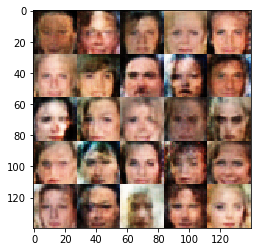

Batch: 2510,  Generator Loss: 1.794, Discriminator Loss: 1.206
Batch: 2520,  Generator Loss: 2.173, Discriminator Loss: 1.353
Batch: 2530,  Generator Loss: 1.350, Discriminator Loss: 1.220
Batch: 2540,  Generator Loss: 2.127, Discriminator Loss: 1.388
Batch: 2550,  Generator Loss: 1.478, Discriminator Loss: 1.149
Batch: 2560,  Generator Loss: 1.705, Discriminator Loss: 1.246
Batch: 2570,  Generator Loss: 1.643, Discriminator Loss: 1.187
Batch: 2580,  Generator Loss: 1.610, Discriminator Loss: 1.148
Batch: 2590,  Generator Loss: 0.913, Discriminator Loss: 1.384
Batch: 2600,  Generator Loss: 1.375, Discriminator Loss: 1.450


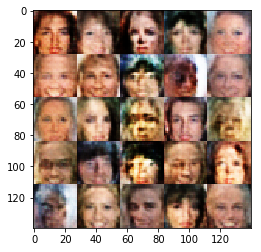

Batch: 2610,  Generator Loss: 1.137, Discriminator Loss: 1.212
Batch: 2620,  Generator Loss: 1.067, Discriminator Loss: 1.181
Batch: 2630,  Generator Loss: 1.132, Discriminator Loss: 1.188
Batch: 2640,  Generator Loss: 1.585, Discriminator Loss: 1.178
Batch: 2650,  Generator Loss: 1.053, Discriminator Loss: 1.223
Batch: 2660,  Generator Loss: 1.310, Discriminator Loss: 1.038
Batch: 2670,  Generator Loss: 2.160, Discriminator Loss: 1.410
Batch: 2680,  Generator Loss: 1.238, Discriminator Loss: 1.008
Batch: 2690,  Generator Loss: 1.430, Discriminator Loss: 1.379
Batch: 2700,  Generator Loss: 0.963, Discriminator Loss: 1.413


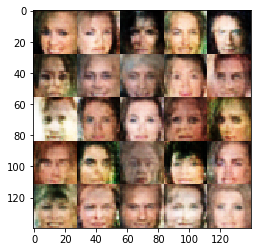

Batch: 2710,  Generator Loss: 1.782, Discriminator Loss: 1.174
Batch: 2720,  Generator Loss: 1.840, Discriminator Loss: 1.138
Batch: 2730,  Generator Loss: 1.695, Discriminator Loss: 1.440
Batch: 2740,  Generator Loss: 1.715, Discriminator Loss: 1.582
Batch: 2750,  Generator Loss: 1.644, Discriminator Loss: 1.046
Batch: 2760,  Generator Loss: 1.652, Discriminator Loss: 1.098
Batch: 2770,  Generator Loss: 1.322, Discriminator Loss: 1.143
Batch: 2780,  Generator Loss: 1.571, Discriminator Loss: 0.976
Batch: 2790,  Generator Loss: 1.647, Discriminator Loss: 1.092
Batch: 2800,  Generator Loss: 2.165, Discriminator Loss: 1.282


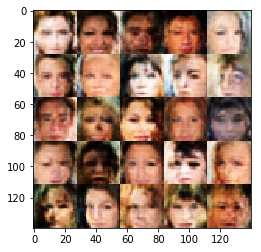

Batch: 2810,  Generator Loss: 1.582, Discriminator Loss: 1.310
Batch: 2820,  Generator Loss: 1.399, Discriminator Loss: 1.341
Batch: 2830,  Generator Loss: 1.584, Discriminator Loss: 1.248
Batch: 2840,  Generator Loss: 1.469, Discriminator Loss: 1.244
Batch: 2850,  Generator Loss: 1.145, Discriminator Loss: 1.170
Batch: 2860,  Generator Loss: 1.650, Discriminator Loss: 1.240
Batch: 2870,  Generator Loss: 1.798, Discriminator Loss: 1.295
Batch: 2880,  Generator Loss: 1.776, Discriminator Loss: 1.362
Batch: 2890,  Generator Loss: 1.237, Discriminator Loss: 1.073
Batch: 2900,  Generator Loss: 1.672, Discriminator Loss: 1.143


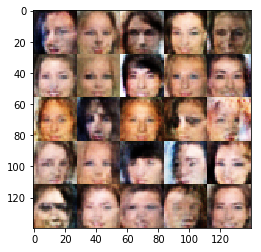

Batch: 2910,  Generator Loss: 1.996, Discriminator Loss: 1.121
Batch: 2920,  Generator Loss: 1.226, Discriminator Loss: 1.104
Batch: 2930,  Generator Loss: 1.095, Discriminator Loss: 1.319
Batch: 2940,  Generator Loss: 1.471, Discriminator Loss: 1.112
Batch: 2950,  Generator Loss: 1.393, Discriminator Loss: 1.054
Batch: 2960,  Generator Loss: 1.167, Discriminator Loss: 1.585
Batch: 2970,  Generator Loss: 0.992, Discriminator Loss: 1.362
Batch: 2980,  Generator Loss: 1.021, Discriminator Loss: 1.395
Batch: 2990,  Generator Loss: 1.128, Discriminator Loss: 1.220
Batch: 3000,  Generator Loss: 1.641, Discriminator Loss: 1.115


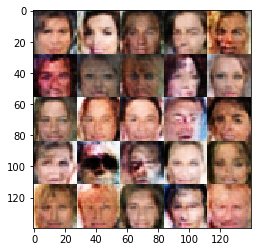

Batch: 3010,  Generator Loss: 1.570, Discriminator Loss: 1.309
Batch: 3020,  Generator Loss: 1.922, Discriminator Loss: 0.917
Batch: 3030,  Generator Loss: 1.217, Discriminator Loss: 1.019
Batch: 3040,  Generator Loss: 1.361, Discriminator Loss: 1.114
Batch: 3050,  Generator Loss: 1.615, Discriminator Loss: 1.277
Batch: 3060,  Generator Loss: 1.696, Discriminator Loss: 1.041
Batch: 3070,  Generator Loss: 1.094, Discriminator Loss: 1.144
Batch: 3080,  Generator Loss: 1.134, Discriminator Loss: 1.106
Batch: 3090,  Generator Loss: 0.806, Discriminator Loss: 1.485
Batch: 3100,  Generator Loss: 1.879, Discriminator Loss: 1.326


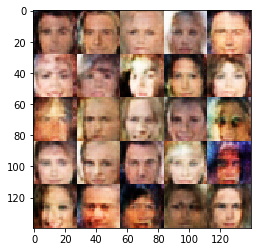

Batch: 3110,  Generator Loss: 1.105, Discriminator Loss: 1.252
Batch: 3120,  Generator Loss: 1.610, Discriminator Loss: 1.258
Batch: 3130,  Generator Loss: 1.826, Discriminator Loss: 1.240
Batch: 3140,  Generator Loss: 1.333, Discriminator Loss: 1.171
Batch: 3150,  Generator Loss: 1.846, Discriminator Loss: 0.930
Batch: 3160,  Generator Loss: 1.255, Discriminator Loss: 1.009
Batch: 3170,  Generator Loss: 2.115, Discriminator Loss: 1.169
Batch: 3180,  Generator Loss: 1.901, Discriminator Loss: 1.020
Batch: 3190,  Generator Loss: 1.211, Discriminator Loss: 1.338
Batch: 3200,  Generator Loss: 0.913, Discriminator Loss: 1.225


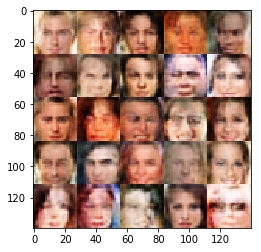

Batch: 3210,  Generator Loss: 1.919, Discriminator Loss: 1.077
Batch: 3220,  Generator Loss: 1.461, Discriminator Loss: 1.099
Batch: 3230,  Generator Loss: 1.831, Discriminator Loss: 1.028
Batch: 3240,  Generator Loss: 1.800, Discriminator Loss: 1.085
Batch: 3250,  Generator Loss: 1.118, Discriminator Loss: 1.217
Batch: 3260,  Generator Loss: 1.349, Discriminator Loss: 1.250
Batch: 3270,  Generator Loss: 1.861, Discriminator Loss: 1.045
Batch: 3280,  Generator Loss: 1.705, Discriminator Loss: 1.173
Batch: 3290,  Generator Loss: 1.177, Discriminator Loss: 1.141
Batch: 3300,  Generator Loss: 1.722, Discriminator Loss: 1.098


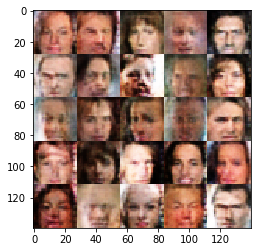

Batch: 3310,  Generator Loss: 1.048, Discriminator Loss: 1.296
Batch: 3320,  Generator Loss: 1.689, Discriminator Loss: 1.167
Batch: 3330,  Generator Loss: 1.201, Discriminator Loss: 1.204
Batch: 3340,  Generator Loss: 3.522, Discriminator Loss: 1.407
Batch: 3350,  Generator Loss: 1.118, Discriminator Loss: 1.263
Batch: 3360,  Generator Loss: 1.623, Discriminator Loss: 0.945
Batch: 3370,  Generator Loss: 1.341, Discriminator Loss: 1.125
Batch: 3380,  Generator Loss: 1.550, Discriminator Loss: 1.136
Batch: 3390,  Generator Loss: 1.990, Discriminator Loss: 1.314
Batch: 3400,  Generator Loss: 0.961, Discriminator Loss: 1.216


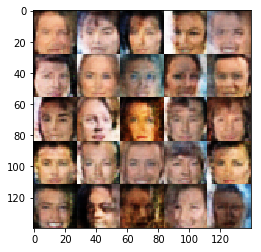

Batch: 3410,  Generator Loss: 1.383, Discriminator Loss: 1.500
Batch: 3420,  Generator Loss: 1.812, Discriminator Loss: 1.154
Batch: 3430,  Generator Loss: 0.926, Discriminator Loss: 1.329
Batch: 3440,  Generator Loss: 1.439, Discriminator Loss: 1.081
Batch: 3450,  Generator Loss: 1.346, Discriminator Loss: 1.320
Batch: 3460,  Generator Loss: 1.642, Discriminator Loss: 1.018
Batch: 3470,  Generator Loss: 1.683, Discriminator Loss: 1.200
Batch: 3480,  Generator Loss: 1.739, Discriminator Loss: 1.050
Batch: 3490,  Generator Loss: 1.772, Discriminator Loss: 1.315
Batch: 3500,  Generator Loss: 1.588, Discriminator Loss: 1.274


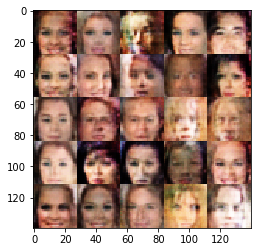

Batch: 3510,  Generator Loss: 1.406, Discriminator Loss: 1.056
Batch: 3520,  Generator Loss: 1.894, Discriminator Loss: 0.991
Batch: 3530,  Generator Loss: 1.459, Discriminator Loss: 1.111
Batch: 3540,  Generator Loss: 1.248, Discriminator Loss: 1.208
Batch: 3550,  Generator Loss: 0.764, Discriminator Loss: 1.517
Batch: 3560,  Generator Loss: 1.675, Discriminator Loss: 1.059
Batch: 3570,  Generator Loss: 2.441, Discriminator Loss: 1.504
Batch: 3580,  Generator Loss: 0.937, Discriminator Loss: 1.203
Batch: 3590,  Generator Loss: 1.917, Discriminator Loss: 0.932
Batch: 3600,  Generator Loss: 1.524, Discriminator Loss: 1.087


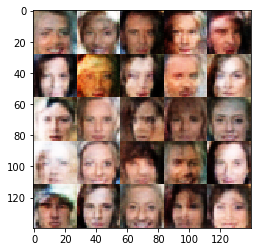

Batch: 3610,  Generator Loss: 1.444, Discriminator Loss: 1.151
Batch: 3620,  Generator Loss: 1.444, Discriminator Loss: 1.064
Batch: 3630,  Generator Loss: 1.559, Discriminator Loss: 1.121
Batch: 3640,  Generator Loss: 1.211, Discriminator Loss: 1.144
Batch: 3650,  Generator Loss: 1.440, Discriminator Loss: 1.068
Batch: 3660,  Generator Loss: 1.400, Discriminator Loss: 1.277
Batch: 3670,  Generator Loss: 1.416, Discriminator Loss: 1.046
Batch: 3680,  Generator Loss: 1.317, Discriminator Loss: 1.157
Batch: 3690,  Generator Loss: 3.363, Discriminator Loss: 1.895
Batch: 3700,  Generator Loss: 1.782, Discriminator Loss: 1.229


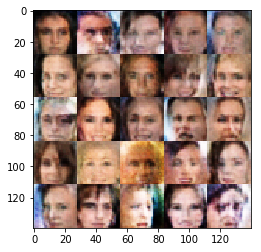

Batch: 3710,  Generator Loss: 1.294, Discriminator Loss: 1.394
Batch: 3720,  Generator Loss: 1.893, Discriminator Loss: 1.207
Batch: 3730,  Generator Loss: 1.171, Discriminator Loss: 1.195
Batch: 3740,  Generator Loss: 1.515, Discriminator Loss: 1.341
Batch: 3750,  Generator Loss: 1.893, Discriminator Loss: 1.036
Batch: 3760,  Generator Loss: 2.204, Discriminator Loss: 1.396
Batch: 3770,  Generator Loss: 0.975, Discriminator Loss: 1.071
Batch: 3780,  Generator Loss: 1.362, Discriminator Loss: 1.078
Batch: 3790,  Generator Loss: 1.683, Discriminator Loss: 1.276
Batch: 3800,  Generator Loss: 1.777, Discriminator Loss: 1.175


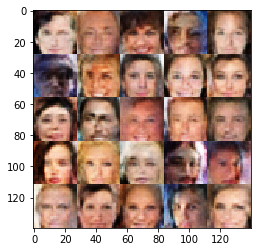

Batch: 3810,  Generator Loss: 0.906, Discriminator Loss: 1.238
Batch: 3820,  Generator Loss: 2.449, Discriminator Loss: 1.224
Batch: 3830,  Generator Loss: 1.500, Discriminator Loss: 1.023
Batch: 3840,  Generator Loss: 1.570, Discriminator Loss: 1.102
Batch: 3850,  Generator Loss: 1.780, Discriminator Loss: 0.984
Batch: 3860,  Generator Loss: 1.868, Discriminator Loss: 1.132
Batch: 3870,  Generator Loss: 1.213, Discriminator Loss: 1.401
Batch: 3880,  Generator Loss: 0.822, Discriminator Loss: 1.588
Batch: 3890,  Generator Loss: 2.148, Discriminator Loss: 1.032
Batch: 3900,  Generator Loss: 2.175, Discriminator Loss: 1.020


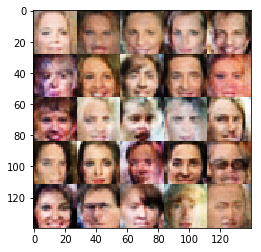

Batch: 3910,  Generator Loss: 1.403, Discriminator Loss: 1.289
Batch: 3920,  Generator Loss: 1.605, Discriminator Loss: 1.165
Batch: 3930,  Generator Loss: 1.072, Discriminator Loss: 1.127
Batch: 3940,  Generator Loss: 1.843, Discriminator Loss: 1.169
Batch: 3950,  Generator Loss: 1.078, Discriminator Loss: 1.163
Batch: 3960,  Generator Loss: 1.361, Discriminator Loss: 1.226
Batch: 3970,  Generator Loss: 1.371, Discriminator Loss: 1.078
Batch: 3980,  Generator Loss: 2.033, Discriminator Loss: 1.279
Batch: 3990,  Generator Loss: 1.689, Discriminator Loss: 1.125
Batch: 4000,  Generator Loss: 1.029, Discriminator Loss: 1.133


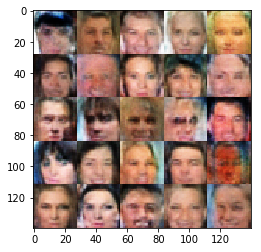

Batch: 4010,  Generator Loss: 2.008, Discriminator Loss: 1.208
Batch: 4020,  Generator Loss: 1.136, Discriminator Loss: 1.139
Batch: 4030,  Generator Loss: 1.843, Discriminator Loss: 1.311
Batch: 4040,  Generator Loss: 1.994, Discriminator Loss: 1.097
Batch: 4050,  Generator Loss: 2.189, Discriminator Loss: 1.290
Batch: 4060,  Generator Loss: 1.825, Discriminator Loss: 1.043
Batch: 4070,  Generator Loss: 1.040, Discriminator Loss: 1.321
Batch: 4080,  Generator Loss: 2.184, Discriminator Loss: 1.111
Batch: 4090,  Generator Loss: 2.009, Discriminator Loss: 1.193
Batch: 4100,  Generator Loss: 0.723, Discriminator Loss: 1.438


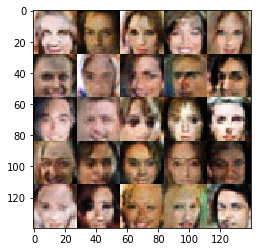

Batch: 4110,  Generator Loss: 1.577, Discriminator Loss: 1.123
Batch: 4120,  Generator Loss: 1.542, Discriminator Loss: 1.270
Batch: 4130,  Generator Loss: 1.730, Discriminator Loss: 1.150
Batch: 4140,  Generator Loss: 1.720, Discriminator Loss: 1.096
Batch: 4150,  Generator Loss: 1.514, Discriminator Loss: 1.171
Batch: 4160,  Generator Loss: 1.288, Discriminator Loss: 1.151
Batch: 4170,  Generator Loss: 1.440, Discriminator Loss: 1.135
Batch: 4180,  Generator Loss: 2.059, Discriminator Loss: 1.202
Batch: 4190,  Generator Loss: 1.905, Discriminator Loss: 1.319
Batch: 4200,  Generator Loss: 1.486, Discriminator Loss: 0.993


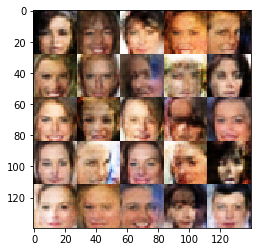

Batch: 4210,  Generator Loss: 3.016, Discriminator Loss: 1.456
Batch: 4220,  Generator Loss: 2.507, Discriminator Loss: 1.476
Batch: 4230,  Generator Loss: 1.800, Discriminator Loss: 1.189
Batch: 4240,  Generator Loss: 1.895, Discriminator Loss: 1.193
Batch: 4250,  Generator Loss: 1.738, Discriminator Loss: 0.969
Batch: 4260,  Generator Loss: 1.568, Discriminator Loss: 1.128
Batch: 4270,  Generator Loss: 1.870, Discriminator Loss: 1.048
Batch: 4280,  Generator Loss: 1.384, Discriminator Loss: 1.092
Batch: 4290,  Generator Loss: 1.303, Discriminator Loss: 1.097
Batch: 4300,  Generator Loss: 2.308, Discriminator Loss: 1.015


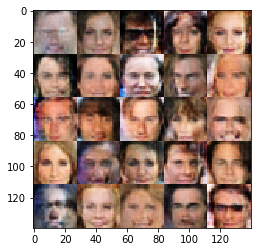

Batch: 4310,  Generator Loss: 2.161, Discriminator Loss: 1.077
Batch: 4320,  Generator Loss: 1.741, Discriminator Loss: 1.228
Batch: 4330,  Generator Loss: 1.941, Discriminator Loss: 1.039
Batch: 4340,  Generator Loss: 1.728, Discriminator Loss: 0.951
Batch: 4350,  Generator Loss: 1.134, Discriminator Loss: 1.381
Batch: 4360,  Generator Loss: 0.908, Discriminator Loss: 1.484
Batch: 4370,  Generator Loss: 1.464, Discriminator Loss: 1.287
Batch: 4380,  Generator Loss: 1.458, Discriminator Loss: 1.293
Batch: 4390,  Generator Loss: 2.137, Discriminator Loss: 1.062
Batch: 4400,  Generator Loss: 2.425, Discriminator Loss: 1.212


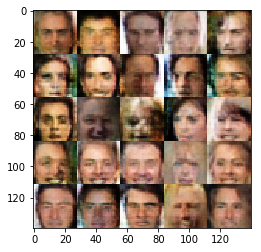

Batch: 4410,  Generator Loss: 1.182, Discriminator Loss: 1.341
Batch: 4420,  Generator Loss: 1.271, Discriminator Loss: 1.200
Batch: 4430,  Generator Loss: 1.754, Discriminator Loss: 0.917
Batch: 4440,  Generator Loss: 1.983, Discriminator Loss: 1.070
Batch: 4450,  Generator Loss: 1.669, Discriminator Loss: 1.095
Batch: 4460,  Generator Loss: 1.461, Discriminator Loss: 1.322
Batch: 4470,  Generator Loss: 1.344, Discriminator Loss: 1.148
Batch: 4480,  Generator Loss: 1.547, Discriminator Loss: 1.200
Batch: 4490,  Generator Loss: 1.196, Discriminator Loss: 1.479
Batch: 4500,  Generator Loss: 1.942, Discriminator Loss: 1.024


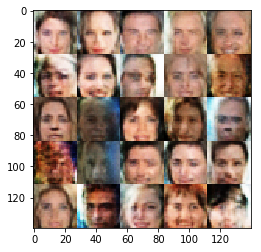

Batch: 4510,  Generator Loss: 0.731, Discriminator Loss: 1.326
Batch: 4520,  Generator Loss: 1.263, Discriminator Loss: 1.057
Batch: 4530,  Generator Loss: 1.759, Discriminator Loss: 0.943
Batch: 4540,  Generator Loss: 2.433, Discriminator Loss: 1.615
Batch: 4550,  Generator Loss: 2.125, Discriminator Loss: 1.035
Batch: 4560,  Generator Loss: 1.532, Discriminator Loss: 1.024
Batch: 4570,  Generator Loss: 2.935, Discriminator Loss: 1.352
Batch: 4580,  Generator Loss: 1.975, Discriminator Loss: 1.113
Batch: 4590,  Generator Loss: 2.185, Discriminator Loss: 1.078
Batch: 4600,  Generator Loss: 1.865, Discriminator Loss: 0.881


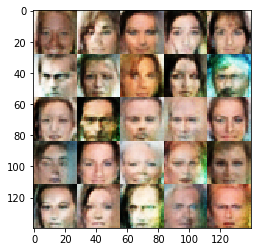

Batch: 4610,  Generator Loss: 1.756, Discriminator Loss: 1.449
Batch: 4620,  Generator Loss: 1.458, Discriminator Loss: 1.193
Batch: 4630,  Generator Loss: 1.441, Discriminator Loss: 1.219
Batch: 4640,  Generator Loss: 1.570, Discriminator Loss: 1.111
Batch: 4650,  Generator Loss: 1.962, Discriminator Loss: 1.318
Batch: 4660,  Generator Loss: 2.248, Discriminator Loss: 1.088
Batch: 4670,  Generator Loss: 1.392, Discriminator Loss: 1.176
Batch: 4680,  Generator Loss: 1.092, Discriminator Loss: 1.077
Batch: 4690,  Generator Loss: 1.198, Discriminator Loss: 1.383
Batch: 4700,  Generator Loss: 2.141, Discriminator Loss: 1.069


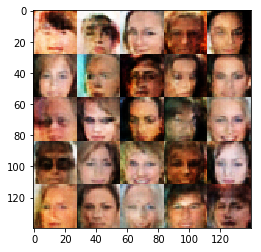

Batch: 4710,  Generator Loss: 2.178, Discriminator Loss: 0.964
Batch: 4720,  Generator Loss: 1.575, Discriminator Loss: 1.178
Batch: 4730,  Generator Loss: 1.424, Discriminator Loss: 1.160
Batch: 4740,  Generator Loss: 1.628, Discriminator Loss: 1.070
Batch: 4750,  Generator Loss: 1.655, Discriminator Loss: 1.209
Batch: 4760,  Generator Loss: 2.456, Discriminator Loss: 1.239
Batch: 4770,  Generator Loss: 1.965, Discriminator Loss: 1.212
Batch: 4780,  Generator Loss: 3.450, Discriminator Loss: 1.354
Batch: 4790,  Generator Loss: 1.189, Discriminator Loss: 1.200
Batch: 4800,  Generator Loss: 2.125, Discriminator Loss: 1.014


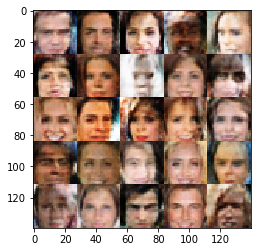

Batch: 4810,  Generator Loss: 1.468, Discriminator Loss: 1.218
Batch: 4820,  Generator Loss: 1.366, Discriminator Loss: 1.152
Batch: 4830,  Generator Loss: 1.463, Discriminator Loss: 1.152
Batch: 4840,  Generator Loss: 2.141, Discriminator Loss: 1.283
Model trained and saved


In [14]:
batch_size = 32
z_dim = 50
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.